In [83]:
import torch
from keypoint_extractor import keypoint_extractor
from biomechanical_features import BiomechanicalFeatureExtractor

extractor = BiomechanicalFeatureExtractor()
features = keypoint_extractor('tiktok_data/halfwaylift/first.mp4')
print(features)

Processed 30/2891 frames (32.09 fps)
Processed 60/2891 frames (36.37 fps)
Processed 90/2891 frames (38.97 fps)
Processed 120/2891 frames (40.57 fps)
Processed 150/2891 frames (40.82 fps)
Processed 180/2891 frames (40.63 fps)
Processed 210/2891 frames (40.94 fps)
Processed 240/2891 frames (41.21 fps)
Processed 270/2891 frames (41.52 fps)
Processed 300/2891 frames (41.78 fps)
Processed 330/2891 frames (41.92 fps)
Processed 360/2891 frames (42.03 fps)
Processed 390/2891 frames (42.20 fps)
Processed 420/2891 frames (42.35 fps)
Processed 450/2891 frames (42.35 fps)
Processed 480/2891 frames (42.35 fps)
Processed 510/2891 frames (42.38 fps)
Processed 540/2891 frames (42.42 fps)
Processed 570/2891 frames (42.36 fps)
Processed 600/2891 frames (42.33 fps)
Processed 630/2891 frames (42.28 fps)
Processed 660/2891 frames (42.31 fps)
Processed 690/2891 frames (42.33 fps)
Processed 720/2891 frames (42.36 fps)
Processed 750/2891 frames (42.37 fps)
Processed 780/2891 frames (42.39 fps)
Processed 810/2

In [84]:
features = torch.from_numpy(features)

In [85]:
velocity = extractor.extract_features(features)["Joint Velocity"]

In [86]:
velocity.shape

torch.Size([2891, 33, 3])

In [59]:
v = torch.sqrt(velocity[..., 0]**2 + velocity[...,1]**2 + velocity[...,2]**2)

In [100]:
s = v.sum(dim=-1)
s.clamp_(max=3)

tensor([0.3571, 0.1667, 0.3930,  ..., 0.8490, 0.2423, 0.2423],
       dtype=torch.float64)

In [101]:
s.shape

torch.Size([2891])

In [102]:
y = torch.arange(len(s))


In [103]:
y.shape

torch.Size([2891])

In [104]:
import matplotlib.pyplot as plt

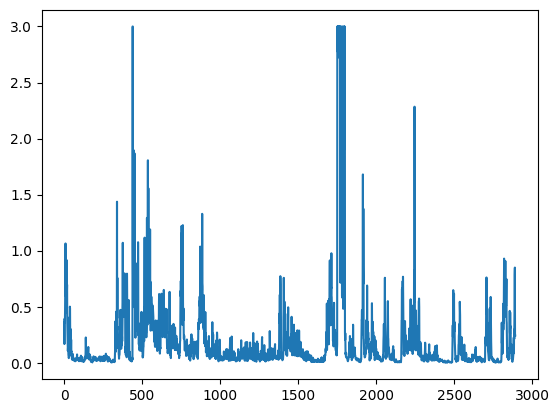

In [105]:
plt.plot(y, s)
plt.show()

In [87]:
a = torch.Tensor([10,1,10])
a.clamp(max=4)

tensor([4., 1., 4.])

In [ ]:
frame_n = [n for ]